In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# LCLS Classic model 

In [2]:
from lcls_live.bmad import LCLSTaoModel
from lcls_live.epics import epics_proxy

import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Make sure this exists
assert 'LCLS_CLASSIC_LATTICE' in os.environ

# Get snapshot

In [4]:
# Cached EPICS pv data
epics = epics_proxy('data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json', verbose=True)

Loaded data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json with 1722 PVs


In [5]:
M = LCLSTaoModel('lcls_classic', epics = epics ,verbose=True, ploton=True)
print(M)

Initialized Tao with /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/tao.init
Loading all settings
Reading: settings/klystron_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/settings/klystron_settings.bmad
Reading: settings/linac_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/settings/linac_settings.bmad
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/settings/coll_settings.bmad
Calling: settings/LEM_settings.tao
Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/settings/LEM_settings.tao
offsetting bunch compressors
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/scripts/BC_offsets.tao
LEMing
call /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_ms4oa2c/tao/scripts/LEM.tao
Configured.
_______________________________________________
_______________________________________________
LCLS Copper Linac EPICS info

Bunch 

In [6]:
%%tao
place floor beta_compare
set lattice base = model

-------------------------
Tao> place floor beta_compare
-------------------------
Tao> set lattice base = model
-------------------------
Tao> 


# Archiver restore

In [7]:
# Optional.
# For archiver, if off-site

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 cmayes@rhel6-64.slac.stanford.edu 
# And then set:
if False:
    os.environ['http_proxy']='socks5h://localhost:8080'
    os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
    os.environ['ALL_PROXY']='socks5h://localhost:8080'
    
    # Restore from some other time
    M.archiver_restore('2018-11-06T11:22:45.000000-08:00')

## Track particles with CSR

In [8]:
%%tao
set beam_init beam_track_end = UNDSTART
set csr_param n_bin = 40
snparticle 10000
set bmad_com csr_and_space_charge_on = T
set csr_param ds_track_step = 0.01
set ele BC1BEG:BC1END CSR_METHOD = 1_dim
set ele BC2BEG:BC2END CSR_METHOD = 1_dim
beamon
beamoff

-------------------------
Tao> set beam_init beam_track_end = UNDSTART
-------------------------
Tao> set csr_param n_bin = 40
-------------------------
Tao> snparticle 10000
-------------------------
Tao> set bmad_com csr_and_space_charge_on = T
-------------------------
Tao> set csr_param ds_track_step = 0.01
-------------------------
Tao> set ele BC1BEG:BC1END CSR_METHOD = 1_dim
[INFO] tao_set_elements_cmd:
    Set successful for 26 elements out of 29
-------------------------
Tao> set ele BC2BEG:BC2END CSR_METHOD = 1_dim
[INFO] tao_set_elements_cmd:
    Set successful for 25 elements out of 28
-------------------------
Tao> beamon
2469 particle(s) lost at element 280: CE11  Total lost: 2469  of 10000
Beam at Element: 1311. Time: 1 min
Total number of lost particles by the end of universe  1:  2469.
-------------------------
Tao> beamoff
-------------------------
Tao> 


In [9]:
h5file1 = os.path.join(os.getcwd(), 'test1.h5')
M.cmd('write beam -at BC2FIN '+h5file1)

['[INFO] tao_write_cmd:',
 '    Written: /Users/chrisonian/Code/GitHub/lcls-live/examples/test1.h5']

In [10]:

h5file2 = os.path.join(os.getcwd(), 'test2.h5')
M.cmd('write beam -at UNDSTART '+h5file2)

['[INFO] tao_write_cmd:',
 '    Written: /Users/chrisonian/Code/GitHub/lcls-live/examples/test2.h5']

# Plot

In [11]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'

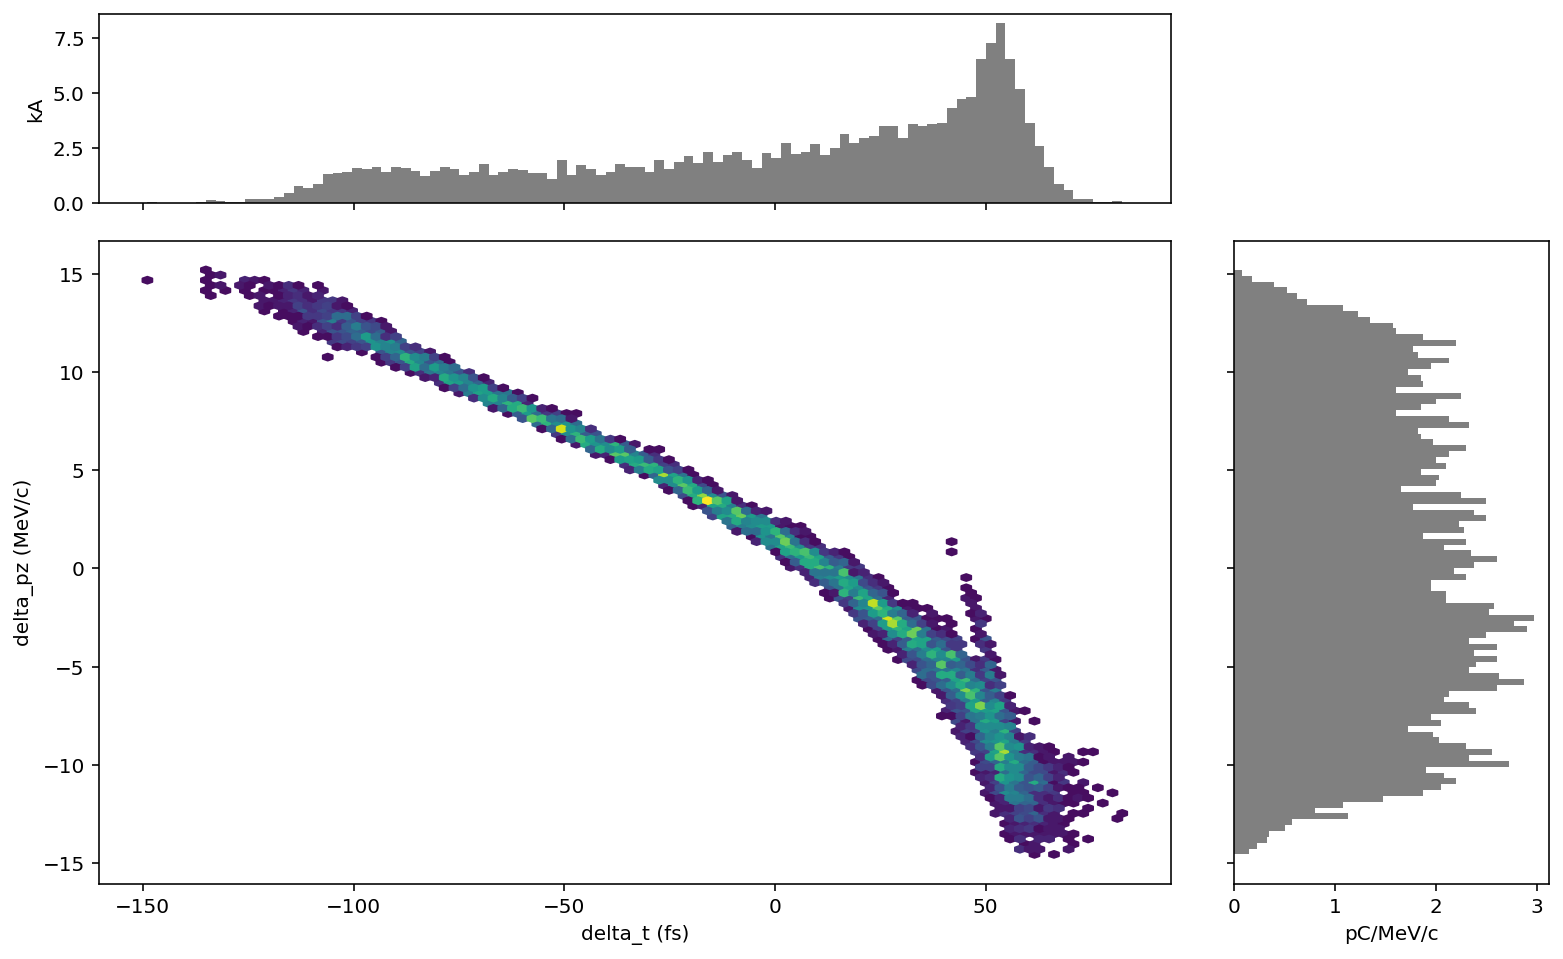

ParticleGroup with 2469 particles with total charge 6.172499999997494e-11 C


In [12]:
P = ParticleGroup(h5file2)
Palive = P.where(P['status'] == 1)
Pdead = P.where(P['status'] != 1)
Palive.plot('delta_t', 'delta_pz', bins=100)
if len(Pdead) >0:
    print(Pdead)

# Functional usage

In [13]:
from lcls_live.bmad.evaluate import run_LCLSTao, evaluate_LCLSTao

In [14]:
settings00 = {
   # 'ele:O_BC1:angle_deg':-5.12345,
   # 'ele:O_BC2:angle_deg':-2.0,
   # 'ele:O_L1:phase_deg':-25.1,
   # 'ele:O_L2:phase_deg':-41.4,
   # 'ele:O_L3:phase_deg':0.0,
   # 'ele:O_L1_fudge:f': 1.0,
   # 'ele:O_L2_fudge:f': 1.0,
   # 'ele:O_L3_fudge:f': 1.0,
    'ele:CE11:x1_limit': 2.5e-3,  # Basic 'horn cutting'
    'ele:CE11:x2_limit': 4.0e-3,
    'csr_param:n_bin':40,
    'csr_param:ds_track_step':0.01,
    'beam_init:n_particle': 10000,
    'beam:beam_saved_at':'CE11, UNDSTART',
    'beam:beam_track_end':'UNDSTART',
    'bmad_com:coherent_synch_rad_on':True,
    'ele:BC1BEG:BC1END:CSR_METHOD': '1_Dim',
    'ele:BC2BEG:BC2END:CSR_METHOD': '1_Dim'
}

M = run_LCLSTao(settings=settings00, model_name='lcls_classic', verbose=True)

Initialized Tao with /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpnmaukkdb/tao/tao.init
Configured.
set global lattice_calc_on = F
set ele CE11 x1_limit = 0.0025
set ele CE11 x2_limit = 0.004
set csr_param  n_bin = 40
set csr_param  ds_track_step = 0.01
set beam_init  n_particle = 10000
set beam  beam_saved_at = CE11, UNDSTART
set beam  beam_track_end = UNDSTART
set bmad_com  coherent_synch_rad_on = True
set ele BC1BEG:BC1END CSR_METHOD = 1_Dim
set ele BC2BEG:BC2END CSR_METHOD = 1_Dim
set global lattice_calc_on = T


Because Tao runs as a library in global space, you can patch in commands:

In [15]:
%%tao
beamoff
set global plot_on = True 
place floor zphase
szpz undstart
x-s floor -.055 -0.02
sc

-------------------------
Tao> beamoff
-------------------------
Tao> set global plot_on = True 
-------------------------
Tao> place floor zphase
[ABORT | 2020-APR-24 10:55:23] tao_graph_phase_space_setup:
    NO BEAM AT ELEMENT: BEGINNING
    CANNOT DO PHASE_SPACE PLOTTING FOR CURVE: zphase.z.c1
-------------------------
Tao> szpz undstart
-------------------------
Tao> x-s floor -.055 -0.02
-------------------------
Tao> sc
-------------------------
Tao> 


In [16]:
# This will run the model, and return a dict with values from the following expressions
expressions = [
    'lat::orbit.x[end]',
    'beam::n_particle_loss[end]'    
]
res = evaluate_LCLSTao(settings=settings00, 
               #  epics_json='data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json',
                 expressions=expressions,
                 beam_archive_path = '.'
                )
res

{'lat::orbit.x[end]': -1.3061669382879e-16,
 'beam::n_particle_loss[end]': 2512.0,
 'beam_archive': '/Users/chrisonian/Code/GitHub/lcls-live/examples/bmad_beam_b3b2ea8989b53efddcf22a308ad30765.h5'}

In [17]:
# Restore something from the archiver
settings00 = {
    'csr_param:n_bin':40,
    'csr_param:ds_track_step':0.01,
    'beam_init:n_particle': 10000,
    'beam:beam_saved_at':'CE11, UNDSTART',
    'beam:beam_track_end':'UNDSTART',
    'bmad_com:coherent_synch_rad_on':True,
    'ele:BC1BEG:BC1END:CSR_METHOD': '1_Dim',
    'ele:BC2BEG:BC2END:CSR_METHOD': '1_Dim'
}


res2 = evaluate_LCLSTao(settings=settings00, 
                 epics_json='data/epics_snapshot_2018-03-06T11:22:45.000000-08:00.json',
                 expressions=expressions,
                 beam_archive_path = '.'
                )
res2

Written: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp7ax_nwcr/tao/settings/coll_settings.bmad


{'lat::orbit.x[end]': -4.1591385527925e-17,
 'beam::n_particle_loss[end]': 2469.0,
 'beam_archive': '/Users/chrisonian/Code/GitHub/lcls-live/examples/bmad_beam_06ee99b928943153fd603a140a159004.h5'}

# Plot

In [18]:
afile = res['beam_archive']
h5 = File(afile, 'r')
ppaths = particle_paths(h5)
ppaths


['/data/00001/particles/', '/data/00002/particles/', '/data/00003/particles/']

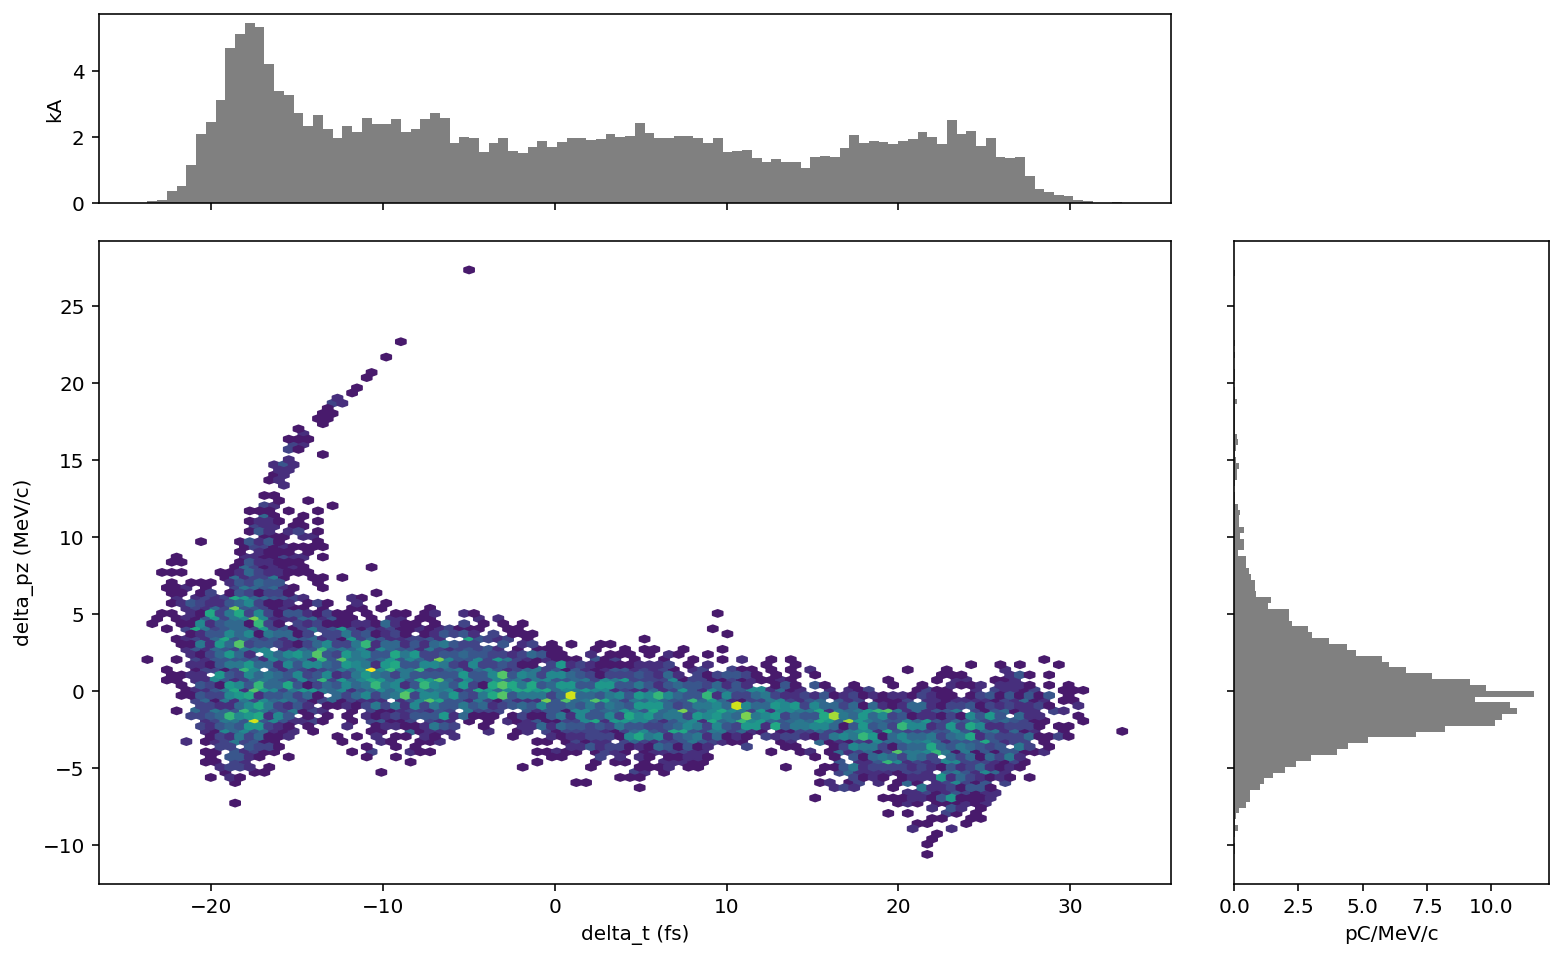

<ParticleGroup with 2512 particles at 0x135e6eb10>

In [19]:
P = ParticleGroup(h5[ppaths[-1]])

Palive = P.where(P['status'] == 1)
Pdead = P.where(P['status'] != 1)
Palive.t *= -1 # Put the head on the right
Palive.plot('delta_t', 'delta_pz', bins=100)
# These particles were lost (probably due to collimation)
Pdead 

In [20]:
# Cleanup
os.remove(h5file1), os.remove(h5file2), os.remove(afile)

(None, None, None)